# Прогнозирование температуры звезды

Необходимо придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. В базе обсерватории есть характеристики уже изученных 240 звёзд:

- Относительная светимость `L/Lo` — светимость звезды относительно Солнца
- Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца
- Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды
- Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа
- Тип звезды
- Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах


Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Содержание
 - [Загрузка и разведочный анализ данных](#getting-data)
 - [Предобработка и анализ данных](#preprocessing)
 - [Построение базовой нейронной сети](#baseline)
 - [Улучшение нейронной сети](#upgrade)
 - [Вывод](#general-conclusion)

Импортируем полезные библиотеки, которые пригодятся нам в будущем

In [1]:
import math
import copy
import tqdm
import numpy as np
import pandas as pd
import phik
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from phik.report import plot_correlation_matrix
from sklearn import set_config
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid

Объявим константы, зададим параметры по умолчанию и создадим функции, которые понадобятся нам в дальнейшем

In [2]:
RANDOM_STATE = 591520
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', size=SMALL_SIZE)                                    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                              # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                              # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                              # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                            # fontsize of the figure title
plt.rc('figure', figsize=(16, 12))                                 # size of the figure
set_config(display='diagram')

# Функция, которая переименовывает цвета звезд
def rename_color(color):
    color = color.lower()
    
    if color in ['blue white', 'blue white ']:
        return 'blue-white'
    elif color == 'blue ':
        return 'blue'
    elif color == 'white-yellow':
        return 'yellow-white'
    elif color == 'yellowish white':
        return 'yellowish-white'
    elif color == 'pale yellow orange':
        return 'pale-yellow-orange'
    else:
        return color
    
# Функция, которая генерирует результаты анализа 
def generate_results(model, X_valid, y_valid):
    temperatures = pd.DataFrame()
    temperatures['Факт'] = y_valid
    temperatures['Прогноз'] = model.predict(X_valid)
    temperatures.sort_index(inplace=True)

    _, ax = plt.subplots(figsize=(16, 4))
    temperatures['Факт'].plot(kind='bar', ax=ax, color='paleturquoise', width=0.8, edgecolor='black');
    temperatures['Прогноз'].plot(kind='bar', ax=ax, color='orange', width=0.4, edgecolor='black');

    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура звезды')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
    plt.show()

    print(f"RMSE: {round(mean_squared_error(temperatures['Факт'], temperatures['Прогноз'], squared=False), 2)}")

<a name="getting-data"></a>
## Загрузка и разведочный анализ данных

#### Получим данные с информацией о характеристиках уже изученных звёзд:

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv', dtype={'Star type':'category', 'Star color': 'category'})

#### Ознакомимся с набором данных. Выведем несколько строк из датафрейма, взятых случайным образом:

In [4]:
data.sample(10, random_state=RANDOM_STATE)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
168,168,17383,342900.0000,30.0000,-6.0900,4,Blue
188,188,2778,0.0008,0.1120,19.4500,0,Red
157,157,20120,4720.0000,6.7800,-3.4000,3,Blue-white
233,233,27739,849420.0000,1252.0000,-7.5900,5,Blue-white
155,155,28700,16790.0000,6.4000,-4.0900,3,Blue-white
161,161,11567,251000.0000,36.0000,-6.2450,4,Blue
178,178,12100,120000.0000,708.9000,-7.8400,5,Blue-white
164,164,8927,239000.0000,35.0000,-7.3400,4,Blue
146,146,12912,0.0007,0.0095,12.8300,2,Blue white
41,41,3365,340000.0000,23.0000,-6.2000,4,Red


#### Отобразим информацию для краткого обзора данных:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Unnamed: 0              240 non-null    int64   
 1   Temperature (K)         240 non-null    int64   
 2   Luminosity(L/Lo)        240 non-null    float64 
 3   Radius(R/Ro)            240 non-null    float64 
 4   Absolute magnitude(Mv)  240 non-null    float64 
 5   Star type               240 non-null    category
 6   Star color              240 non-null    category
dtypes: category(2), float64(3), int64(2)
memory usage: 10.7 KB


#### Посчитаем количество пропущенных значений:

In [6]:
data.isna().sum()

Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

#### Отобразим таблицу с описательной статистикой признаков:

In [7]:
data.describe()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,240.0000,240.0000,240.0000,240.0000,240.0000
mean,119.5000,10497.4625,107188.3616,237.1578,4.3824
std,69.4262,9552.4250,179432.2449,517.1558,10.5325
min,0.0000,1939.0000,0.0001,0.0084,-11.9200
25%,59.7500,3344.2500,0.0009,0.1027,-6.2325
50%,119.5000,5776.0000,0.0705,0.7625,8.3130
75%,179.2500,15055.5000,198050.0000,42.7500,13.6975
max,239.0000,40000.0000,849420.0000,1948.5000,20.0600


#### Отобразим таблицу с попарными корреляциями признаков:

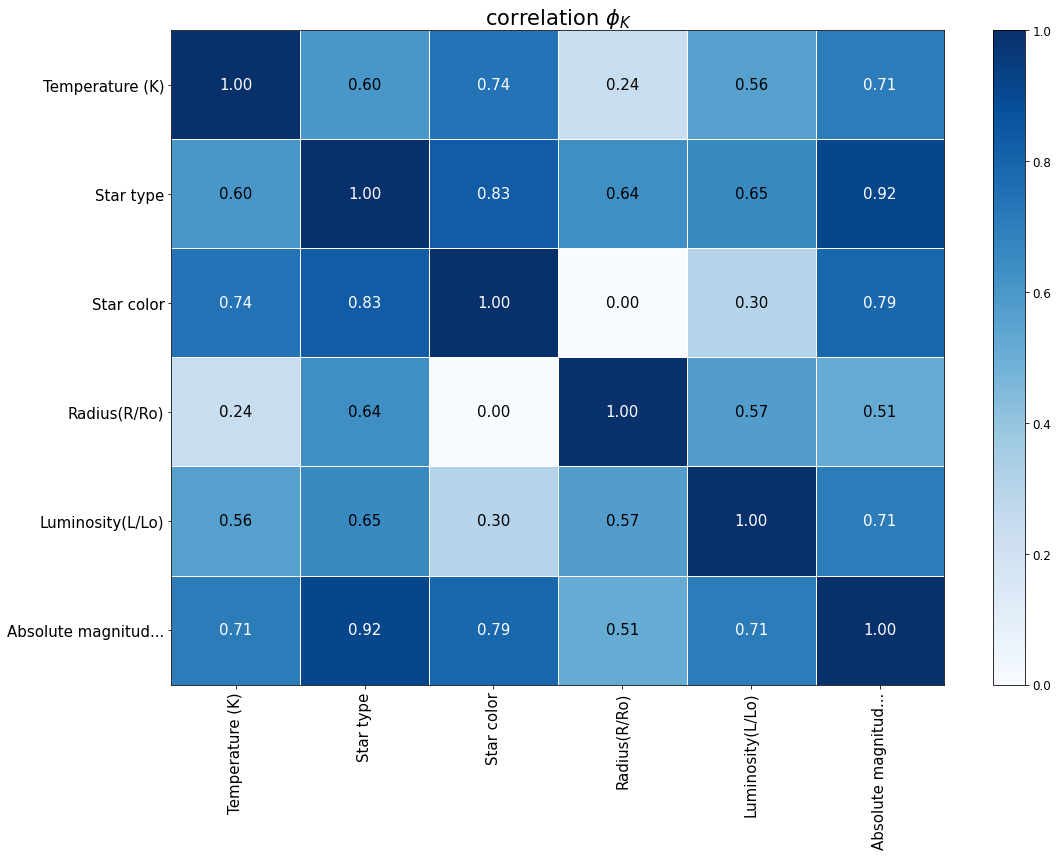

In [8]:
phik_columns = data.columns.difference(['Unnamed: 0'])
phik_overview = data[phik_columns].phik_matrix(interval_cols=phik_columns.difference(['Star type', 'Star color']))
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(16, 12))
plt.tight_layout()

#### Отобразим гистограммы распределений значений признаков:

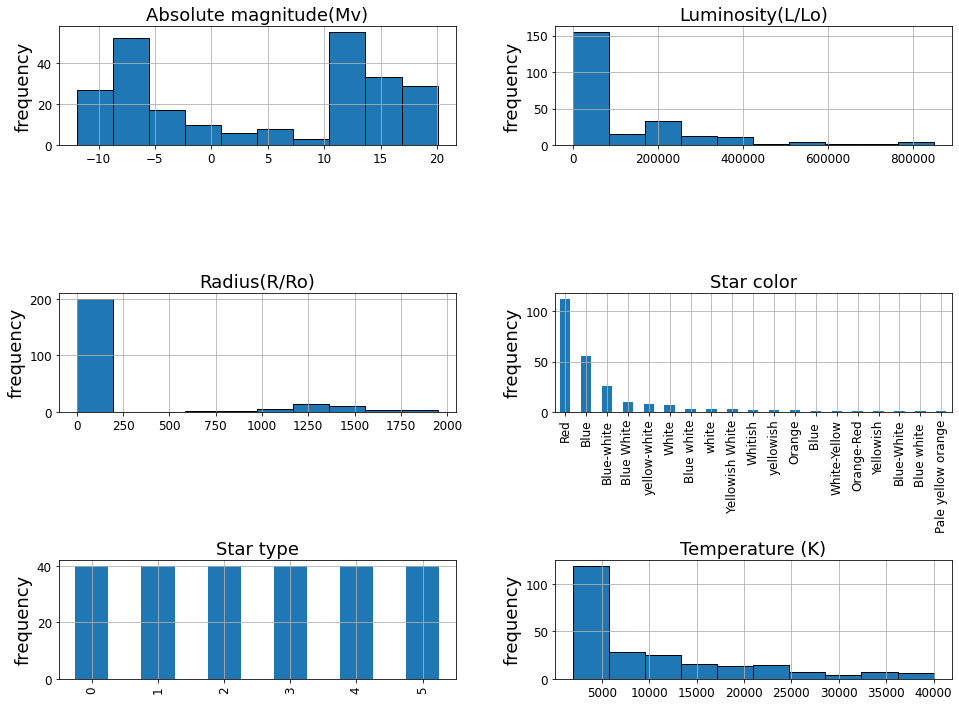

In [9]:
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(wspace=0.25, hspace=1.25)

for i, col in enumerate(data.columns.difference(['Unnamed: 0'])):
    ax = fig.add_subplot(3, 2, i + 1)
    
    # Отобразим количественные и категориальные переменные соответствующими методами
    if pd.api.types.is_categorical_dtype(data[col]):
        data[col].value_counts().plot(kind='bar')
    else:
        data[col].plot(kind='hist', edgecolor='black')
    
    ax.set_title(col)
    ax.set_ylabel('frequency')
    ax.grid(visible=True)

#### Краткий вывод:
- в данных присутствуют всего $240$ объектов
- в данных присутствуют нарушения правила хорошего стиля в названиях столбцов
- в данных присутствует неинформативный столбец — `Unnamed: 0`
- в данных отсутствуют несоответствия типов в столбцах 
- в данных отсутствуют пропуски в столбцах
- в данных присутствуют неявные дубликаты в столбце `Star color`, например `Blue-white` и `Blue white`
- в данных присутствуют аномальные значения
- в данных присутствуют намёки на мультиколлинеарность
- наиболее вероятный цвет звезды — `Red`
- столбец `Star type` имеет равномерное распределение, то есть имеется по $40$ звёзд на каждый тип

<a name="preprocessing"></a>
## Предобработка и анализ данных

#### Удалим неинформативные столбцы, которые не несут ценности для прогноза:

In [10]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

#### Исправим нарушения правил хорошего стиля в названиях столбцов:

In [11]:
data.rename(inplace=True, columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'absolute_magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'
})

#### Очистим данные от дубликатов:

In [12]:
# check
data.duplicated().sum()

0

In [13]:
data['star_color'] = data['star_color'].apply(rename_color).astype('category')

#### Очистим данные от аномальных значений:

Так как количество объектов невелико (всего $240$ объектов), оставим данные на этом этапе без изменений

#### Создадим базовый pipeline с предобработкой данных:

- учтём, что число объектов в данных не велико, и отдадим предпочтение технике кодирования `OrdinalEncoding`, чтобы не увеличивать размерность данных. Закодируем признаки `star_type` и `star_color` при помощи `OrdinalEncoder`
- можно заметить, что признак `star_type` был закодирован ещё при создании данных и техника `OrdinalEncoding` никак не изменит закодированые значения
- проскалируем количественные признаки при помощи `StandardScaler`

In [14]:
categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, ['star_type', 'star_color']),
        ('numerical', numeric_transformer, ['luminosity', 'radius', 'absolute_magnitude'])
    ]
)

base_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
base_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['star_type', 'star_color']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['luminosity', 'radius',
                                                   'absolute_magnitude'])]))])

#### Проведём графический анализ данных:

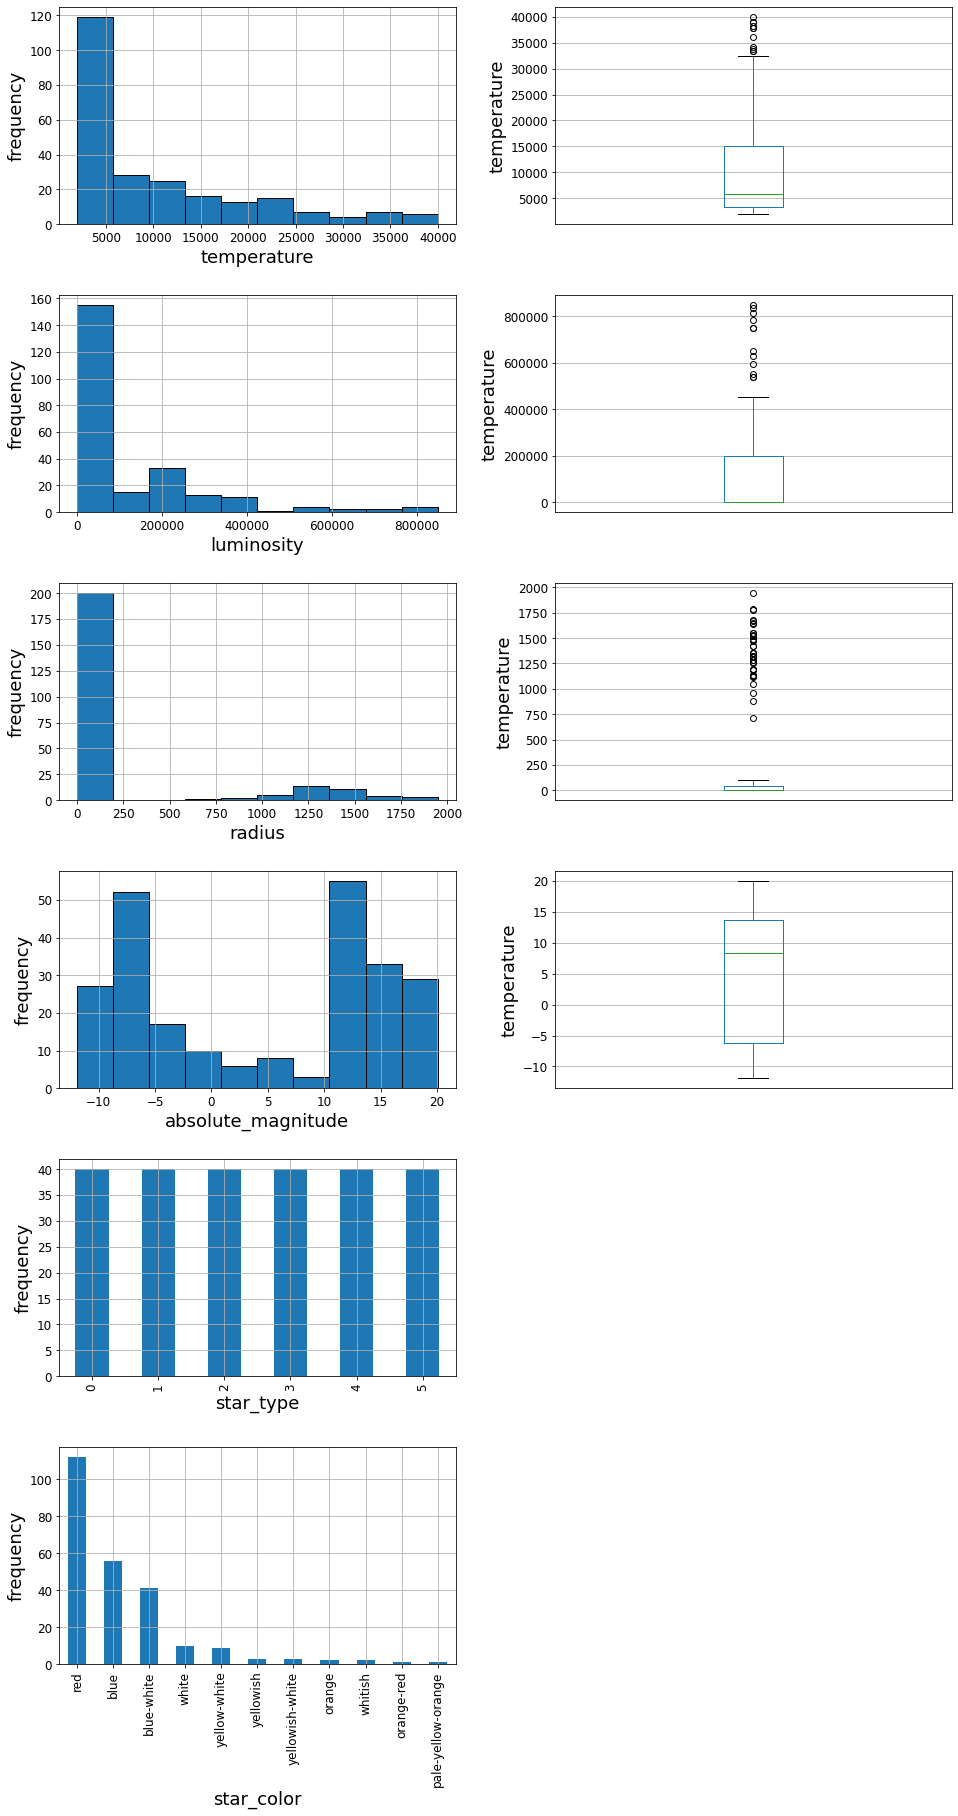

In [15]:
subfigures = plt.figure(figsize=(16, 24)).subfigures(6, 1)
plt.subplots_adjust(wspace=0.25, hspace=0.25)

for i, col in enumerate(data.columns):    
    ax = subfigures[i].subplots(1, 2)
    
    # Отобразим количественные и категориальные переменные соответствующими методами
    if pd.api.types.is_categorical_dtype(data[col]):
        data[col].value_counts().plot(kind='bar', ax=ax[0])
        subfigures[i].delaxes(ax[1])
    else:
        data[col].plot(kind='hist', ax=ax[0], edgecolor='black')
        data.boxplot(column=col, ax=ax[1])

    ax[0].set_ylabel('frequency')
    ax[1].set_ylabel('temperature')
    ax[0].set_xlabel(col)
    ax[1].get_xaxis().set_visible(False)
    ax[0].grid(visible=True)
    ax[1].grid(visible=True)

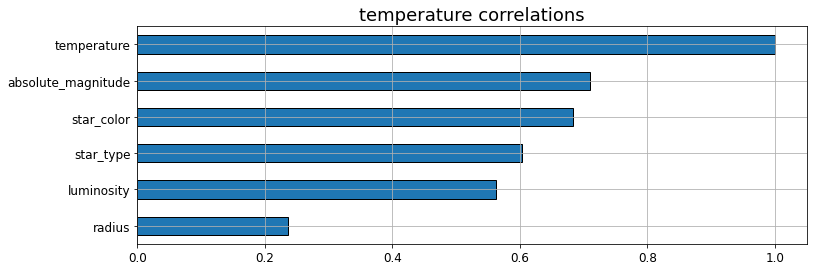

In [16]:
phik_overview = data.phik_matrix(interval_cols=data._get_numeric_data().columns)['temperature'].sort_values()
phik_overview.plot(kind='barh', figsize=(12, 4), edgecolor='black', title='temperature correlations', grid=True);

#### Подготовим обучающую и валидационную выборки:

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop(columns=['temperature'], axis=1),
                                                      data['temperature'],
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      random_state=RANDOM_STATE)

#### Краткий вывод:
- в данных были устранены неявные дубликаты в столбце `star_color`
- радиус звезды имеет бимодальное распределение, точно также как относительная светимость и абсолютная звёздная величина

<a name="baseline"></a>
## Построение базовой нейронной сети

#### Создадим классы для нейронной сети, которые понадобятся нам в дальнейшем:

In [18]:
# Класс полносвязной нейронной сети с произвольным числом слоёв и нейронов на каждом слое
class Net(nn.Module):
    def __init__(self, layers_neurons, dropout_layers, act_functions):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(layers_neurons[i], layers_neurons[i+1]) for i in range(len(layers_neurons) - 1)])
        self.dropout_layers = nn.ModuleList(dropout_layers)
        self.act_functions = nn.ModuleList(act_functions)
        
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.dropout_layers[i](x)
            x = self.act_functions[i](x)
            
        return x
    
# Класс модели нейронной сети для работы с библиотекой sklearn
class NNRegressor(BaseEstimator):
    def __init__(self, net, optimizer, num_epochs=1000, batch_size=512, verbose=False, verbose_epochs=100, **parameters):
        self.net = net
        self.optimizer = optimizer
        self.loss = nn.MSELoss()
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.verbose_epochs = verbose_epochs
        
        if 'dropout_probs' in parameters:
            for i in range(len(parameters['dropout_probs'])):
                self.net.dropout_layers[i].p = parameters['dropout_probs'][i]
        
    def get_params(self, deep=True):
        return {
            'net' : self.net,
            'optimizer': self.optimizer,
            'loss': self.loss,
            'num_epochs': self.num_epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose,
            'verbose_epochs': self.verbose_epochs
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        if 'dropout_probs' in parameters:
            for i in range(len(parameters['dropout_probs'])):
                self.net.dropout_layers[i].p = parameters['dropout_probs'][i]
            
        return self
        
    def fit(self, X_train, y_train):                               
        if isinstance(X_train, (pd.DataFrame, pd.Series)):
            X_train = X_train.to_numpy(copy=True)
        if isinstance(y_train, (pd.DataFrame, pd.Series)):
            y_train = y_train.to_numpy(copy=True)

        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train)
        
        num_batches = math.ceil(len(X_train) / self.batch_size)
        self.net.train()
        
        for epoch in range(self.num_epochs):
            order = np.random.permutation(len(X_train))
            
            for batch_idx in range(num_batches):
                start_index = batch_idx * self.batch_size
                self.optimizer.zero_grad()
        
                batch_indexes = order[start_index:start_index+self.batch_size]
                X_batch = X_train[batch_indexes]
                y_batch = y_train[batch_indexes]

                preds = self.net.forward(X_batch).flatten()
                loss_value = self.loss(preds, y_batch)
                loss_value.backward()
                self.optimizer.step()

            if self.verbose and epoch % self.verbose_epochs == 0:
                print(loss_value)

    def predict(self, X_test):
        if isinstance(X_test, (pd.DataFrame, pd.Series)):
            X_test = X_test.to_numpy(copy=True)

        self.net.eval()
        return self.net.forward(torch.FloatTensor(X_test)).detach().numpy().flatten()

#### Создадим базовую нейронную сеть:

- добавим два скрытых слоя, каждый из которых будет состоять из $100$ нейронов
- добавим два слоя `Dropout` с вероятностями $p=0.5$
- будем использовать только функцию `ReLU` в качестве функции активации
- инициализируем веса в обоих слоях при помощи инициализации Кайминга

In [19]:
net = Net([5, 100, 100, 1], [nn.Dropout(0.5), nn.Dropout(0.5), nn.Identity()], [nn.ReLU(), nn.ReLU(), nn.Identity()])
nn.init.kaiming_uniform_(net.layers[0].weight, mode='fan_in', nonlinearity='relu')
nn.init.kaiming_uniform_(net.layers[1].weight, mode='fan_in', nonlinearity='relu') 
net

Net(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): Identity()
  )
  (act_functions): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): Identity()
  )
)

#### Создадим pipeline для baseline модели:

In [20]:
baseline_net = copy.deepcopy(net)
baseline_model = Pipeline(steps=[
    ('preprocessor', base_pipeline), 
    ('neural_network',  NNRegressor(baseline_net, 
                                    torch.optim.Adam(baseline_net.parameters(), lr=1e-2),
                                    num_epochs=1000,
                                    batch_size=16,
                                    verbose=True, 
                                    verbose_epochs=100))
])
baseline_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['star_type',
                                                                    'star_color']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['luminosity',
                                                                    'radius',
                                                                    'absolute_magnitude'])]))])),
                ('...
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): Identity()
  )
  (act_functions): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): Identity()
  )
),
                             optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
),
                             verbose=True))])

#### Обучим baseline модель:

In [21]:
baseline_model.fit(X_train, y_train)

tensor(1.9137e+08, grad_fn=<MseLossBackward0>)
tensor(12186639., grad_fn=<MseLossBackward0>)
tensor(16457176., grad_fn=<MseLossBackward0>)
tensor(29384950., grad_fn=<MseLossBackward0>)
tensor(69037872., grad_fn=<MseLossBackward0>)
tensor(25172528., grad_fn=<MseLossBackward0>)
tensor(7859718., grad_fn=<MseLossBackward0>)
tensor(17570748., grad_fn=<MseLossBackward0>)
tensor(34861240., grad_fn=<MseLossBackward0>)
tensor(49570932., grad_fn=<MseLossBackward0>)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['star_type',
                                                                    'star_color']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['luminosity',
                                                                    'radius',
                                                                    'absolute_magnitude'])]))])),
                ('...
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): Identity()
  )
  (act_functions): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): Identity()
  )
),
                             optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
),
                             verbose=True))])

#### Проанализируем результаты обучения модели:

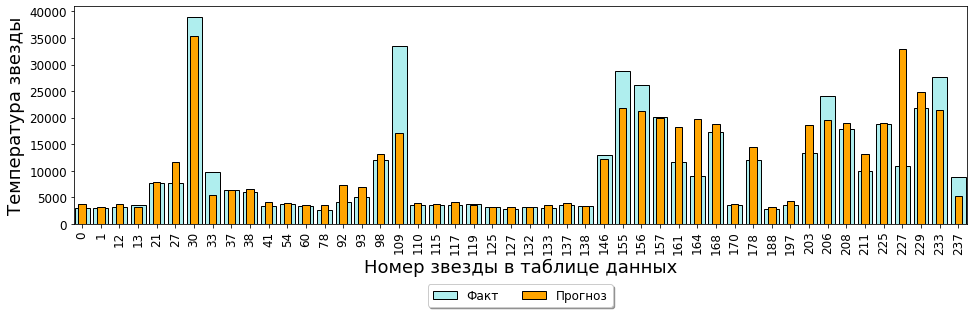

RMSE: 4954.62


In [22]:
generate_results(baseline_model, X_valid, y_valid)

#### Краткий вывод:
- базовая модель неплохо справилась со своей задачей. На первый взгляд предсказания модели достаточно близки к реальным данным
- как уже было сказано ранее, в данных присутствует определённое количество звёзд с аномальными значениями абсолютной температуры. Базовая модель достаточно хорошо справилась со многими такими аномальными объектами, но не со всеми

<a name="upgrade"></a>
## Улучшение нейронной сети

#### Найдём наилучшую модель базовой нейронной сети:

Будем перебирать два гиперпараметра — `batch_size` и `dropout_probs`

In [25]:
models = []
scores = []
param_grid = {
    'batch_size': [2, 4, 8, 16, 32, 64, 192], 
    'dropout_probs': [[p1, p2] for p1 in np.linspace(0.0, 0.8, 9) for p2 in np.linspace(0.0, 0.8, 9)]
}

for params in tqdm.tqdm(list(ParameterGrid(param_grid))):
    baseline_net = copy.deepcopy(net)
    model = Pipeline(steps=[
        ('preprocessor', base_pipeline), 
        ('neural_network', NNRegressor(baseline_net,
                                       torch.optim.Adam(baseline_net.parameters(), lr=1e-2),
                                       num_epochs=1000,
                                       batch_size=params['batch_size'],
                                       dropout_probs=params['dropout_probs']))
    ])

    model.fit(X_train, y_train)
    models.append(model)
    scores.append(round(mean_squared_error(y_valid, model.predict(X_valid), squared=False), 2))

100%|██████████| 567/567 [6:25:19<00:00, 40.77s/it]  


#### Проанализируем результаты обучения моделей:

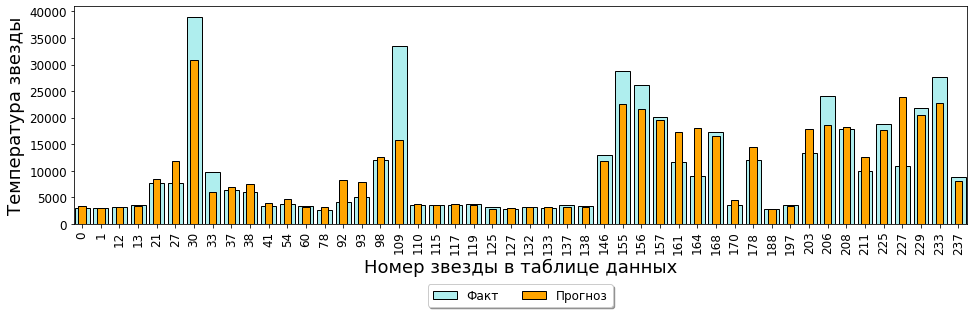

RMSE: 4271.95


In [26]:
best_model = models[scores.index(min(scores))]
generate_results(models[scores.index(min(scores))], X_valid, y_valid)

#### Краткий вывод:
- лучшая по результатам перебора гиперпараметров модель показала меньшее значение `RMSE`чем `baseline` модель
- тем не менее лучшая модель всё-таки не смогла хорошо спрогнозировать абсолютную температуру для некоторых аномальных значений 

<a name="general-conclusion"></a>
## Вывод
- в данных присутствуют всего $240$ объектов. Среди них есть звёзды с аномальными значениями абсолютной температуры, которые крайне сложно спрогнозировать
- базовая модель неплохо справилась со своей задачей. На первый взгляд предсказания модели достаточно близки к реальным данным
- лучшая по результатам перебора гиперпараметров модель показала меньшее значение `RMSE`чем `baseline` модель
- тем не менее лучшая модель всё-таки не смогла хорошо спрогнозировать абсолютную температуру для некоторых аномальных значений 